In [31]:
!pip install emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Assignment-6
Devananth V - EP20BTECH11004

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt 
import scipy
from sklearn.linear_model import BayesianRidge
from scipy.optimize import curve_fit 
from scipy import stats, ndimage
import emcee

Q1

In [34]:
ein_pred=1.74
new_pred=ein_pred/2 
edd_pred=(1.61,0.4)
cro_pred= (1.98,0.16)

new_pdf=np.empty (2, dtype= object)
new_pdf[0]=stats.norm(new_pred, edd_pred[1]).pdf (edd_pred[0])
new_pdf[1]=stats.norm(new_pred, cro_pred[1]).pdf(cro_pred[0])
ein_pdf = np.empty(2, dtype = object)
ein_pdf [0]=stats.norm(ein_pred, edd_pred[1]).pdf (edd_pred[0])
ein_pdf [1]=stats.norm(ein_pred,cro_pred[1]).pdf(cro_pred[0])
bayes = (new_pdf[0]*new_pdf [1])/(ein_pdf [0] *ein_pdf [1])
print("Bayes factor between General Relativity and Newtonian gravity:",bayes)

Bayes factor between General Relativity and Newtonian gravity: 2.0762126610332088e-11


Q2

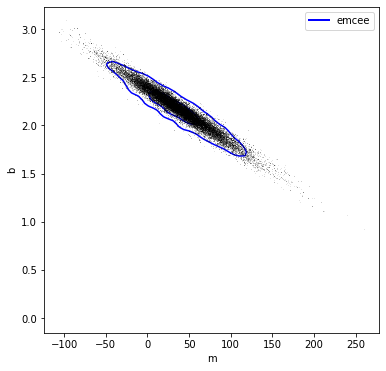

In [35]:
def log_prior(theta):
  alpha, beta, sigma = theta
  if sigma < 0:
    return -np.inf
  else:
    return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_llihood(theta, x, y):
  a, b, s = theta
  y_model = a + b * x
  return -0.5 * np.sum(np.log(2 * np.pi * s ** 2) + (y - y_model) ** 2 / s ** 2)

def log_posterior(theta, x, y):
  return log_prior(theta) + log_llihood(theta, x, y)

def sigma_level(t1, t2, nbins=20, smoothing=3):
  L, xbins, ybins = np.histogram2d(t1, t2, nbins)
  L[L == 0] = 1E-16
  logL = np.log(L)
  shape = L.shape
  L = L.ravel()
  i_sort = np.argsort(L)[::-1]
  i_unsort = np.argsort(i_sort)
  L_cumsum = L[i_sort].cumsum()
  L_cumsum /= L_cumsum[-1]
  sigma = L_cumsum[i_unsort].reshape(shape)
  if smoothing > 1:
    sigma = ndimage.zoom(sigma, smoothing)
    xbins = np.linspace(xbins[0], xbins[-1], sigma.shape[0] + 1)
    ybins = np.linspace(ybins[0], ybins[-1], sigma.shape[1] + 1)
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])
    return xbins, ybins, sigma

def plot_MCMC(ax, xdata, ydata, t, scatter=False, nbins=20, smoothing=3, **kwargs):
  xbins, ybins, sigma = sigma_level(t[0], t[1], nbins, smoothing)
  ax.contour(xbins, ybins, sigma.T, levels=[0.68 ** 2, 0.95 ** 2], **kwargs)
  if scatter:
    ax.plot(t[0], t[1], ',k', alpha=0.1)
    ax.set_xlabel('m')
    ax.set_ylabel('b')

data =  np.loadtxt("data.txt" ,unpack = True)
x,y,sig_y = data[1], data[2], data[3]  
ndim = 3
nwalk = 50
nburn = 1000
nsteps = 2000
guess = np.random.random((nwalk, ndim))
sampler = emcee.EnsembleSampler(nwalk, ndim, log_posterior,args=[x, y])
sampler.run_mcmc(guess, nsteps)
emc = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
fig, ax = plt.subplots(figsize=(6,6))
plot_MCMC(ax, x, y, emc, True, colors='b', linewidths=1.5)
ax.plot([0, 0], [0, 0], 'b', lw=2,label="emcee")
plt.legend()
plt.show()

 Q3

<ipython-input-49-89fa81b9e9c9>:25: RuntimeWarning: divide by zero encountered in log
  lL2 = np.log(1 - temp) - 0.5 * np.log(2 * np.pi * sigmaB ** 2)
<ipython-input-49-89fa81b9e9c9>:23: RuntimeWarning: divide by zero encountered in log
  lL1 = np.log(temp) - 0.5 * np.log(2 * np.pi * sigmay ** 2)


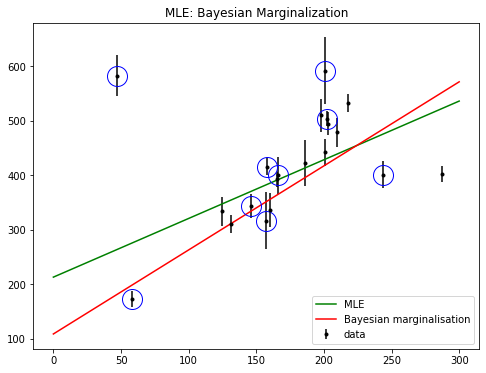

In [49]:
dat =  np.loadtxt("dat.txt" ,unpack = True)
x,y,sig_y = dat[1], dat[2], dat[3] 

def mse(theta, x=x, y=y, sig_y=sig_y):
  dy = y - theta[0] - theta[1] * x
  return np.sum(0.5 * (dy / sig_y) ** 2)

def huber_loss(t, c=3):
  return ((abs(t) < c) * 0.5 * t ** 2 + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, x=x, y=y, sig_y=sig_y, c=3):
  return huber_loss((y - theta[0] - theta[1] * x) / sig_y, c).sum()

def log_prior(theta):
  if 1 > all(theta[2:]) > 0:
    return 0
  else:
    return -np.inf

def log_llhood(theta, x, y, sigmay, sigmaB):
  dy = y - theta[0] - x*theta[1]
  temp = np.clip(theta[2:], 0, 1)
  lL1 = np.log(temp) - 0.5 * np.log(2 * np.pi * sigmay ** 2)
  lL1=lL1- 0.5 * (dy / sigmay) ** 2
  lL2 = np.log(1 - temp) - 0.5 * np.log(2 * np.pi * sigmaB ** 2)
  lL2+=- 0.5 * ((dy / sigmaB) ** 2)
  su = np.sum(np.logaddexp(lL1, lL2))
  return su

def log_posterior(theta, x, y, sigmay, sigmaB):
  return log_prior(theta) + log_llhood(theta, x, y, sigmay, sigmaB)

theta1 = scipy.optimize.fmin(mse, [0, 0], disp=False)
theta2 = scipy.optimize.fmin(total_huber_loss, [0, 0], disp=False)
x_1 = np.linspace(0, 300, 1000)
ndim = 2 + len(x)
nwalk = 50
nburn = 10000
nsteps = 15000 
start_gues = np.zeros((nwalk, ndim))
start_gues[:, :2] = np.random.normal(theta2, 1, (nwalk, 2))
start_gues[:, 2:] = np.random.normal(0.5, 0.1, (nwalk, ndim - 2))
sampler = emcee.EnsembleSampler(nwalk, ndim, log_posterior, args=[x, y, sig_y, 50])
sampler.run_mcmc(start_gues, nsteps)
sample = sampler.chain
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.495)
plt.figure(figsize=(8,6))
plt.errorbar(x, y, sig_y, fmt='.k', label='data')
plt.plot(x_1, theta1[0] + x_1*theta1[1], color='g', label='MLE')
plt.plot(x_1, theta3[0] + x_1* theta3[1] , color='r', label='Bayesian marginalisation')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='b')
plt.legend()
plt.title('MLE: Bayesian Marginalization');
plt.show()

<ipython-input-38-e79dae74e30b>:23: RuntimeWarning: divide by zero encountered in log
  lL1 = np.log(temp) - 0.5 * np.log(2 * np.pi * sigmay ** 2)
<ipython-input-38-e79dae74e30b>:25: RuntimeWarning: divide by zero encountered in log
  lL2 = np.log(1 - temp) - 0.5 * np.log(2 * np.pi * sigmaB ** 2)


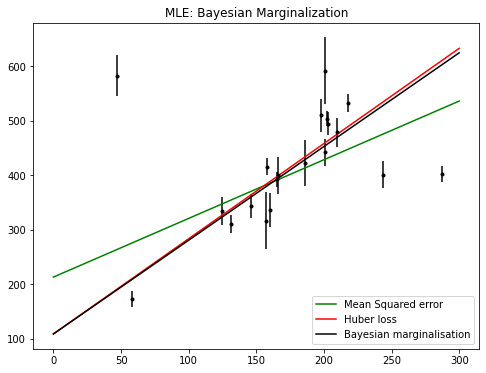

In [39]:
ndim = 2 + len(x)
nwalk = 50
nburn = 10000
nsteps = 15000 
start_gues = np.zeros((nwalk, ndim))
start_gues[:, :2] = np.random.normal(theta2, 1, (nwalk, 2))
start_gues[:, 2:] = np.random.normal(0.5, 0.1, (nwalk, ndim - 2))
sampler = emcee.EnsembleSampler(nwalk, ndim, log_posterior, args=[x, y, sig_y, 50])
sampler.run_mcmc(start_gues, nsteps)
sample = sampler.chain
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.48)
plt.figure(figsize=(8,6))
plt.errorbar(x, y, sig_y, fmt='.k', label='data')
plt.plot(x_1, theta1[0] + x_1*theta1[1], color='g', label='MLE')
plt.plot(x_1, theta3[0] + x_1* theta3[1] , color='black', label='Bayesian marginalisation')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='b')
plt.legend()
plt.title('MLE: Bayesian Marginalization');
plt.show()